In [197]:
# Druhy TOI projekt
# Autor sablony: Jan Beran, 2024, Tomas Goldmann 2025
# Jmeno resitele/resitelky: Alexej Beňuš
# xlogin: xbenus01


# Zde si pripradne pridejte vlastni importy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats # možná se vám bude hodit pro statistické testy

from statsmodels.tsa.statespace.sarimax import SARIMAX

In [198]:
# Roku 2023 si nevšímejte, data jsou aktuální. :)
t_avg = pd.read_csv("http://janberan.tech/wp-content/uploads/2023/02/T_avg.csv")
t_min = pd.read_csv("http://janberan.tech/wp-content/uploads/2023/02/T_min.csv")
t_max = pd.read_csv("http://janberan.tech/wp-content/uploads/2023/02/T_max.csv")
rain = pd.read_csv("http://janberan.tech/wp-content/uploads/2023/02/rain.csv")
wind = pd.read_csv("http://janberan.tech/wp-content/uploads/2023/02/wind.csv")
air = pd.read_csv("http://janberan.tech/wp-content/uploads/2023/02/Kvalita_ovzdusi___Air_quality.csv")

# Deskriptivní analýza

Jako první rovnou oříznu data z air, ačkoliv to doporučujete až v dalším kroku, zdá se mi validní rovnou kontrolovat pouze zadané data.

Poté vypíšu jednoduché statistiky u všech datasetů.

In [199]:
#Filter air
air_filtered = air[air['name'] == 'Brno-Tuřany']
air_filtered = air_filtered[['actualized', 'no2_1h', 'pm10_1h', 'pm2_5_1h']]
air_filtered['actualized'] = pd.to_datetime(air_filtered['actualized'], format='%Y/%m/%d %H:%M:%S%z')


In [200]:
def air_description(df: pd.DataFrame) -> None:
    summary = []

    variable_columns = [col for col in df.columns if col not in ['date', 'time']]
    
    for var in variable_columns:
        data = df[['actualized', var]].dropna(subset=[var])

        if not data.empty:
            start_timestamp = data['actualized'].min()
            end_timestamp = data['actualized'].max()
            average = round(data[var].mean(), 2)
            maximum = data[var].max()
            minimum = data[var].min()
        else:
            start_timestamp = end_timestamp = None
            average = maximum = minimum = None

        missing_values = df[var].isna().sum()
        total_values = data[var].count()

        summary.append({
            'Variable': var,
            'Start Timestamp': start_timestamp,
            'End Timestamp': end_timestamp,
            'Missing Values': missing_values,
            'Total Values': total_values,
            'Average': average,
            'Max': maximum,
            'Min': minimum
        })

    
    summary_df = pd.DataFrame(summary)
    print(summary_df)

In [201]:
def basic_description(df: pd.DataFrame) -> None:

    summary = []
    
    day_columns = [col for col in df.columns if col not in ['rok', 'měsíc']]
    
    # Flatten all the day values into one big series
    all_values = df[day_columns].stack().dropna()
    
    if not all_values.empty:
        # !!! CHATGPT GENERATED !!!
        # Start and end (based on first and last non-missing value)
        first_valid = df.loc[(df[day_columns].notna()).any(axis=1)].iloc[0]
        last_valid = df.loc[(df[day_columns].notna()).any(axis=1)].iloc[-1]
        start_year_month = (first_valid['rok'], first_valid['měsíc'])
        end_year_month = (last_valid['rok'], last_valid['měsíc'])
        # !!! END CHATGPT GENERATED !!!
        average = round(all_values.mean(), 2)
        maximum = all_values.max()
        minimum = all_values.min()
    else:
        start_year_month = end_year_month = (None, None)
        average = maximum = minimum = None

    missing_values = df[day_columns].isna().sum().sum()
    
    total_values = all_values.count()

    # Store in summary table
    summary.append({
        'Start Year-Month': start_year_month,
        'End Year-Month': end_year_month,
        'Missing Values': missing_values,
        'Total Values': total_values,
        'Average': average,
        'Max': maximum,
        'Min': minimum
    })
    
    summary_df = pd.DataFrame(summary)
    print(summary_df)
    return



In [202]:
basic_description(t_min)
basic_description(t_avg)
basic_description(t_max)
basic_description(rain)
basic_description(wind)

air_description(air_filtered)

  Start Year-Month  End Year-Month  Missing Values  Total Values  Average  \
0    (1961.0, 1.0)  (2022.0, 12.0)             425         22639     5.03   

    Max   Min  
0  24.2 -24.1  
  Start Year-Month  End Year-Month  Missing Values  Total Values  Average  \
0    (1961.0, 1.0)  (2022.0, 12.0)             425         22639      9.4   

    Max   Min  
0  30.8 -19.9  
  Start Year-Month  End Year-Month  Missing Values  Total Values  Average  \
0    (1961.0, 1.0)  (2022.0, 12.0)             425         22639    13.92   

    Max   Min  
0  37.8 -16.7  
  Start Year-Month  End Year-Month  Missing Values  Total Values  Average  \
0    (1961.0, 1.0)  (2022.0, 12.0)             426         22638     1.37   

    Max  Min  
0  82.1  0.0  
  Start Year-Month  End Year-Month  Missing Values  Total Values  Average  \
0    (1961.0, 1.0)  (2022.0, 12.0)             426         22638     3.47   

    Max  Min  
0  17.3  0.0  
     Variable                                    Start Timestamp  \
0

|Teplota v ˚C| Hodnota |
|----------------------|-------- |
|**Jméno datasetu**    | T_min.csv \ T_avg.csv \ T_max.csv |
|**Rozsah a četnost**  | 1.1.1961 - 31.12.2022, celkem 22639, chybějící 425 |
|**Maximum**           | 24.2 \ 30.8 \ 37.8 |
|**Minimum**           | -24.1 \ -19.9 \ -16.7 |
|**Aritmetický průměr**| 5.03 \ 9.4 \ 13.92 |
|**Popis dat, co bude třeba upravit** | Viz níže |
-----
|Srážky v mm | Hodnota |
|----------------------|-------- |
|**Jméno datasetu**    | rain.csv |
|**Rozsah a četnost**  | 1.1.1961 - 31.12.2022, celkem 22638, chybějící 426 |
|**Maximum**           | 82.1 |
|**Minimum**           | 0.0 |
|**Aritmetický průměr**| 1.37 |
|**Popis dat, co bude třeba upravit** | Viz níže |
-----
|Rychlost větru v m/s | Hodnota |
|----------------------|-------- |
|**Jméno datasetu**    | wind.csv |
|**Rozsah a četnost**  | 1.1.1961 - 31.12.2022, celkem 22638, chybějící 426 |
|**Maximum**           | 17.3 |
|**Minimum**           | 0.0 |
|**Aritmetický průměr**| 3.47 |
|**Popis dat, co bude třeba upravit** | Viz níže |

Data jsou na první pohled kompletní, ve všech datasetech chybí 425/426, což by přibližnou matematikou mělo sedět na chybějící dny v některých měsících.
Například únor 27/28 dní a některé měsíce 30 - tedy hrubou matematikou - 62 let, 47 normálních, 15 přestupných, v normálním roce 4x1 + 1x3, v přestupném 4x1 + 1x3 - tedy +-419 dní, což přibližně sedí. Tedy nějaké hodnoty chybějí, ale v tomhle množství se to bude dát vyřešit jednoduchým doplněním průměru z okolních dní.

Data jsou stejně jako rain a wind v otřesném formátu, proto je později zformátuji do formátu date | value a dám je všechny do stejného dataframu pro jednodušší porovnatelnost mezi sebou.

Také se data budou muset ořezat, aby seděly s následujícím datasetem.

Nevypadá, že by v těchto datasetech byly nesmyslné hodnoty, minimálně ne z těchto jednoducých parametrů.

-----
-----
|Kvalita ovzduší | Hodnota |
|----------------------|-------- |
|**Jméno datasetu**    | no2_1h \ pm10_1h \ pm2_5_1h |
|**Rozsah a četnost**  | 9.2.2022 13:37:45 - 9.2.2023 13:43:57 |
|**Maximum**           | 75.8 \ 331.0 \ 109.0 |
|**Minimum**           | 1.0 \ 1.0 \ 0.0 |
|**Aritmetický průměr**| 13.05 \ 17.49 \ 11.26 |
|**Popis dat, co bude třeba upravit** | Viz níže |

U no2_1h chybí 1421 dat, u pm10_1h chybí 1149 dat a u pm2_5_1h chybí 0 dat. Což vzhledem k celkovému počtu měření 6804 u všech hodnot, je nezanedbatelný počet. Tedy určitě se budou data muset doplňovat. Také se data vzhledem k intervalu měření budou muset agregovat na jednodenní intervaly.

Nevypadá, že by v tomto datasetu byly nesmyslné hodnoty, minimálně ne z těchto jednoducých parametrů.

## Shrnutí

V podstatě se data rozdělily na 2 skupiny. Kvalita vzduchu a teplota+vítr+srážky.

Jasný problém je datum začátku sběru dat. Vzduchové data se týkají pouze jednoho roku zatímco druhá skupina dat sbírá data 60 let.

Také je problém v časovém intervalu dat. Jedny data se sbírají jednou za den, druhá skupina dat se sbírá přibližně každou hodinu.

Datové řady taky mají podivné struktury, takže se musí sjednotit.

**Cíle**

Tedy cíle jsou jasné:

1. Vyfiltrovat data abychom měli pouze překrývající se části, tedy jeden rok Únor 2022 - Únor 2023. 

2. Zjednotnění časového intervalu, tedy mít data pouze za každý den. Příjde mi vhodnější z několika měření v jednom dni udělat průměr a jeden den, než z jednoho měření dělat více.

3. Stejná struktura dat. Udělat nový dataframe, ve kterém data budou mít stejnou strukturu. 

**Hypotézy**

Déšť bude souviset s teplotou, tedy teplota bude klesat, když bude pršet, protože déšť je studený, takže ochladí i okolí.

Vítr bude souviset s teplotou, tedy teplota bude klesat, čím více bude foukat.

Prach a pyl bude souviset s deštěm, tedy počet částic prachu a pylu ve vzduchu bude klesat, když bude pršet - myšlenka je v tom, že vlhkost tento prach a pyl pohltí, čímž klesne k zemi.

Malý prach a velký prach spolu budou souviset, tedy větší koncentrace jednoho bude ekvivalentní s vyšší koncentrací druhého - nejsem fyzik, ale tipuju, že větší prach se může rozpadnout na menší a vice versa, tedy spolu budou jistě souviset.

Koncetrace oxidu dusičitého může souviset s koncentrací menšího polétavého prachu, jelikož oboje se produkuje ve spalovacích motorech.

Sezónní korelace dat taky budou hrát roli, ale ne po celý rok. Tedy tyto vztahy nesedí na jednotlivé časové řady obecně, ale pouze ve specifický čas, což je ale taky jistá korelace dat.

1. V chladnějších měsících (nižší teplota) bude více prachu ve vzduchu (lidé více topí, ačkoliv netuším jaké kotle se využívají v Brně, na vesnici by tato korelace byla)
2. Jaro a podzim, kdy je průměrná teplota (v porovnání se zimou a létem) budou větší srážky.
3. Na jaře by mělo být hodně pylu, tedy koncentrace pylu.

# Příprava dat

V této sekci budu postupovat následovně:

Zatím nebudu spojovat datasety, jelikož musí proběhnout agregace u druhého a kontrola obou datasetů.
Tedy, jako první změním strukturu prvního datasetu aby se s ním dalo rozumně pracovat.
Zkontroluju u ubou datasetů nevalidní hodnoty, doplním chybějící atd. Poté zagreguju druhý dataset. Poté oříznu první a až poté je spojím.

**Krok 1.**

Úprava prvního datasetu s teplotou, větrem a srážkami. až po úpravě budu hledat chybějící hodnoty a nesmyslné hodnoty.

In [203]:
# Helper function to melt and prepare each dataset
def prepare_df(df: pd.DataFrame, value_name: str) -> pd.DataFrame:
    df_melted = df.melt(id_vars=['rok', 'měsíc'], var_name='day', value_name=value_name)
    df_melted['day'] = df_melted['day'].astype(int)
    df_melted['date'] = pd.to_datetime(dict(year=df_melted['rok'], month=df_melted['měsíc'], day=df_melted['day']), errors='coerce')
    df_melted = df_melted[['date', value_name]]
    df_melted = df_melted.dropna(subset=['date'])  # drop invalid dates like 30 Únor
    return df_melted

# Prepare all datasets
t_avg_melted = prepare_df(t_avg, 'T_avg')
t_min_melted = prepare_df(t_min, 'T_min')
t_max_melted = prepare_df(t_max, 'T_max')
rain_melted = prepare_df(rain, 'Rain')
wind_melted = prepare_df(wind, 'Wind')

# Merge everything on 'date'
df_analysis = t_avg_melted.merge(t_min_melted, on='date', how='outer')
df_analysis = df_analysis.merge(t_max_melted, on='date', how='outer')
df_analysis = df_analysis.merge(rain_melted, on='date', how='outer')
df_analysis = df_analysis.merge(wind_melted, on='date', how='outer')

# Set date format
df_analysis['date'] = pd.to_datetime(df_analysis['date'], format='%Y-%m-%d')

# Sort by date
df_analysis = df_analysis.sort_values('date').reset_index(drop=True)

# For Prediction of anomalies in 4th assignment
df_anomalies = df_analysis.copy(deep=True)

**Kontrola chybějících hodnot**

In [204]:
# Check for missing values in the merged DataFrame
missing_dates = df_analysis[df_analysis.isna().any(axis=1)]
print("Dates with missing values:")
print(missing_dates[['date', 'T_avg', 'T_min', 'T_max', 'Rain', 'Wind']])

df_analysis[['T_avg', 'T_min', 'T_max', 'Rain', 'Wind']] = df_analysis[['T_avg', 'T_min', 'T_max', 'Rain', 'Wind']].interpolate(method='linear')

missing_dates = df_analysis[df_analysis.isna().any(axis=1)]
print("Dates with missing values:")
print(missing_dates[['date', 'T_avg', 'T_min', 'T_max', 'Rain', 'Wind']])

Dates with missing values:
            date  T_avg  T_min  T_max  Rain  Wind
21425 2019-08-30   24.3   18.4   29.6   0.0   NaN
22338 2022-02-28    1.0   -2.0    4.0   NaN   4.1
22395 2022-04-26    NaN    NaN    NaN   NaN   NaN
22396 2022-04-27    NaN    NaN    NaN   NaN   NaN
22397 2022-04-28    NaN    NaN    NaN   NaN   NaN
22398 2022-04-29    NaN    NaN    NaN   NaN   NaN
22399 2022-04-30    NaN    NaN    NaN   NaN   NaN
22430 2022-05-31    NaN    NaN    NaN   NaN   NaN
Dates with missing values:
Empty DataFrame
Columns: [date, T_avg, T_min, T_max, Rain, Wind]
Index: []


In [205]:
# Check for missing values in air_filtered
missing_dates_air = air_filtered[air_filtered.isna().any(axis=1)]
print("Dates with missing values in air_filtered:")
print(missing_dates_air[['actualized', 'no2_1h', 'pm10_1h', 'pm2_5_1h']])

# Interpolate missing values in air_filtered
air_filtered[['no2_1h', 'pm10_1h', 'pm2_5_1h']] = air_filtered[['no2_1h', 'pm10_1h', 'pm2_5_1h']].interpolate(method='linear')
# Check again for missing values
missing_dates_air = air_filtered[air_filtered.isna().any(axis=1)]
print("Dates with missing values in air_filtered after interpolation:")
print(missing_dates_air[['actualized', 'no2_1h', 'pm10_1h', 'pm2_5_1h']])


Dates with missing values in air_filtered:
                     actualized  no2_1h  pm10_1h  pm2_5_1h
29    2022-02-09 15:37:45+00:00     NaN      5.0       3.0
126   2022-02-10 01:37:48+00:00     NaN      NaN       0.0
154   2022-02-10 04:37:51+00:00     NaN      NaN       0.0
249   2022-02-10 13:37:57+00:00     NaN     12.0      12.0
474   2022-02-11 12:38:11+00:00     NaN     17.0       8.0
...                         ...     ...      ...       ...
67323 2023-02-05 23:43:25+00:00     NaN     14.2       6.6
67537 2023-02-06 22:43:27+00:00     NaN     32.6      28.7
67729 2023-02-07 21:43:29+00:00     NaN     23.3      26.2
67927 2023-02-08 20:43:56+00:00     NaN     16.0       8.5
68040 2023-02-09 12:43:56+00:00     NaN      NaN       0.0

[1424 rows x 4 columns]
Dates with missing values in air_filtered after interpolation:
Empty DataFrame
Columns: [actualized, no2_1h, pm10_1h, pm2_5_1h]
Index: []


**Kontrola outliers**

In [206]:
# Check for outliers using z-score method
def check_outliers(df: pd.DataFrame, column: str) -> pd.DataFrame:
    z_scores = np.abs(stats.zscore(df[column].dropna()))
    threshold = 3
    outliers = df[(z_scores > threshold) & (df[column].notna())]
    return outliers

In [207]:
# Check outliers in the merged DataFrame

for column in ['T_avg', 'T_min', 'T_max', 'Rain', 'Wind']:
    outliers = check_outliers(df_analysis, column)
    print(f"Outliers in {column}:")
    print(outliers[['date', column]])
    print("\n")

# Check outliers in air_filtered
for column in ['no2_1h', 'pm10_1h', 'pm2_5_1h']:
    outliers = check_outliers(air_filtered, column)
    print(f"Outliers in {column}:")
    print(outliers[['actualized', column]])
    print("\n")


Outliers in T_avg:
            date  T_avg
2565  1968-01-10  -16.4
8770  1985-01-05  -17.0
8771  1985-01-06  -17.9
8772  1985-01-07  -19.9
8773  1985-01-08  -18.8
9507  1987-01-12  -19.7
9508  1987-01-13  -18.6
13144 1996-12-27  -16.5
13146 1996-12-29  -16.6
16458 2006-01-23  -18.1
16459 2006-01-24  -16.5


Outliers in T_min:
            date  T_min
358   1961-12-25  -17.8
746   1963-01-17  -18.7
747   1963-01-18  -19.0
748   1963-01-19  -17.5
759   1963-01-30  -19.6
762   1963-02-02  -20.8
763   1963-02-03  -20.0
764   1963-02-04  -19.7
765   1963-02-05  -19.0
767   1963-02-07  -18.1
787   1963-02-27  -18.3
788   1963-02-28  -18.9
789   1963-03-01  -18.6
2565  1968-01-10  -18.8
2566  1968-01-11  -21.0
2569  1968-01-14  -21.3
3277  1969-12-22  -19.4
3656  1971-01-05  -17.7
7659  1981-12-21  -18.2
7682  1982-01-13  -17.6
7683  1982-01-14  -18.6
8770  1985-01-05  -22.9
8771  1985-01-06  -21.2
8772  1985-01-07  -24.1
8773  1985-01-08  -21.6
8774  1985-01-09  -22.3
8808  1985-02-12  -22.2


Z-score nedohalilo žádné nesmyslně velké, nebo malé hodnoty, tedy považuji datasety za validní, jelikož již nemají žádné chybějící data, ani nesmyslné data.

Nyní již zbývá pouze agregace dat, oříznutí starých dat a spojení do jednoho df.

Po spojení jsem zjistil, že chybí pár datumů u měření kvality vzduchu, tedy jsem data opět doplnil.

In [208]:
# Aggregate the air data by day
air_daily = air_filtered.resample('D', on='actualized').mean().reset_index()
air_daily['actualized'] = air_daily['actualized'].dt.strftime('%Y-%m-%d')

# Merge the air data with the weather data
df_analysis['date'] = df_analysis['date'].dt.strftime('%Y-%m-%d')
df_analysis = df_analysis.merge(air_daily, left_on='date', right_on='actualized', how='left')

# cut dates before and after air data collection
df_analysis = df_analysis[df_analysis['date'] >= '2022-02-09']
df_analysis = df_analysis.drop(columns=['actualized'])

# Check for missing values in the merged DataFrame
missing_dates = df_analysis[df_analysis.isna().any(axis=1)]

for column in ['no2_1h', 'pm10_1h', 'pm2_5_1h']:
    df_analysis[column] = df_analysis[column].interpolate(method='linear')

df_analysis = df_analysis.rename(columns={
    'no2_1h': 'no2',
    'pm10_1h': 'pm10',
    'pm2_5_1h': 'pm2_5'
})

# Check the merged DataFrame
print(df_analysis.head())
print(df_analysis.tail())
print(df_analysis.describe())
print(df_analysis.info())
# 

             date  T_avg  T_min  T_max  Rain  Wind        no2       pm10  \
22319  2022-02-09   6.10    3.0    9.2   0.0   3.2  20.427273   8.636364   
22320  2022-02-10   7.00    2.0   12.0   0.0   2.4  14.491667  13.541667   
22321  2022-02-11   5.50    2.0    9.0   0.0   4.3  15.020833  14.166667   
22322  2022-02-12   2.00   -2.0    6.0   0.3   2.8  12.891667  14.416667   
22323  2022-02-13   1.85   -3.0    6.7   0.0   4.6   4.608333  11.604167   

           pm2_5  
22319   7.000000  
22320  11.000000  
22321  10.083333  
22322   9.250000  
22323   8.250000  
             date  T_avg  T_min  T_max  Rain  Wind        no2       pm10  \
22640  2022-12-27   4.00    1.0    7.0   1.0   3.8  10.279545   5.954545   
22641  2022-12-28   0.60   -2.0    3.2   0.0   1.4  20.473684   5.368421   
22642  2022-12-29   1.00   -2.0    4.0   0.0   1.7  13.661364  12.931818   
22643  2022-12-30   0.55   -1.0    2.1   0.0   1.0  16.828571  16.023810   
22644  2022-12-31   5.65    1.0   10.3   0.3   1.

## Shrnutí

Data byla oříznuta na únor 2022 až prosinec 2022, kvůli druhého datasetu, který se začal měřit až v únoru 22 a prosinec, kvůli toho, že zde první dataset končí.

Struktura se změnila do jednorozměrného pole pro každou měřenou veličinu s datem jako index.

Interpolací sousedních hodnot byly doplněny chybějící hodnoty. Jako první se doplnily hodnoty v rámci jednotlivých datasetů a až poté byly doplněny chybějící hodnoty v rámci dnů, které například nebyly vůbec měřeny.

Změnena byla také frekvence měření u druhého setu, kde se data agregovaly na jednodenní intervaly, místo hodinových měření. 

# Část 3: Analýza dat

V této části budete anaylzovat své časové řady. Není zde připravena žádná šablona, jelikož každý můžete používat rozdílné struktury uložení dat - a různé postupy - které povedou ke sprévnému výsledku.

V souboru se zadáním je ovšem zmíněno několik funkcí, které vám mohou pomoci.

Stručné zadání:
Pro dvojice dat, pro které jste zformulovali hypotézy v části 1, a pro 3 libovolně zvolené jiné dvojice časových řad (jiné než ty, pro které jste formulovali hypotézy a nikoli dvě sady teplotních údajů) zjistěte:
1) Kovarianci
2) Pearsonův korelační koeficient
3) Statistickou významnost koeficientu

In [209]:
def test_correlation(df: pd.DataFrame, var1: str, var2: str) -> dict:
    r, p_value = stats.pearsonr(df[var1], df[var2])
    
    result = {
        'Variable 1': var1,
        'Variable 2': var2,
        'Correlation Coefficient (r)': round(r, 3),
        'p-value': round(p_value, 3),
        'Significant': p_value < 0.05
    }
    
    return result

In [210]:
# My hopotheses
hypotheses = [
    ('T_avg', 'Rain'),        # Rain vs Temperature
    ('T_avg', 'Wind'),        # Wind vs Temperature
    ('Rain', 'pm10'),         # Rain vs Big dust particles
    ('Rain', 'pm2_5'),        # Rain vs Small dust particles
    ('pm10', 'pm2_5'),        # Big dust vs Small dust
    ('no2', 'pm2_5'),         # NO2 vs Small dust
]

# Some randomly chosen hypotheses
random_hypotheses = [
    ('Wind', 'T_max'),        # Max temp vs Wind
    ('Wind', 'T_min'),        # Min temp vs Wind
    ('Rain', 'T_max'),        # Max temp vs Rain
    ('Rain', 'T_min'),        # Min temp vs Rain
    ('Wind', 'pm10'),         # Wind vs Big dust
    ('T_avg', 'no2'),         # NO2 vs Average temperature
]

all_tests = hypotheses + random_hypotheses

In [211]:
# Run all tests
results = []
for var1, var2 in all_tests:
    res = test_correlation(df_analysis, var1, var2)
    results.append(res)

results_df = pd.DataFrame(results)

# Show results
print(results_df)

   Variable 1 Variable 2  Correlation Coefficient (r)  p-value  Significant
0       T_avg       Rain                        0.138    0.013         True
1       T_avg       Wind                       -0.102    0.065        False
2        Rain       pm10                       -0.138    0.012         True
3        Rain      pm2_5                       -0.127    0.022         True
4        pm10      pm2_5                        0.802    0.000         True
5         no2      pm2_5                        0.586    0.000         True
6        Wind      T_max                       -0.114    0.040         True
7        Wind      T_min                       -0.080    0.148        False
8        Rain      T_max                        0.080    0.149        False
9        Rain      T_min                        0.202    0.000         True
10       Wind       pm10                       -0.206    0.000         True
11      T_avg        no2                       -0.391    0.000         True


Výsledky hypotéz mě překvapily. S 95% jistotou můžeme říct, že souvisí všechny mnou vyslovené hypotézy až na vítr a teplotu.

0. Průměrná teplota se zvedá s deštěm, což je překvapivé. Předpokládal jsem opačný vztah.
1. Průměrná teplota nezávisí na větru.
2. S deštěm se zmenšuje počet částic ve vzduchu. Předpovězeno správně.
3. S deštěm se zmenšuje počet částic ve vzduchu. Předpovězeno správně.
4. Velká korelace mezi velkými a malými částicemi ve vzduchu. Tedy, čím více menších, tím více větších částic. Předpovězeno správně.
5. Zde se ukazuje korelace malých částic (ze spalovacích motorů) s oxidem dusičitým. Předpovězeno správně.
----
6. S vyšším větrem, klesá maximální teplota.
7. S vyšším větrem, sice klesá minimální teplota, ale ne statisticky významně.
8. Déšť statisticky neovlivňuje maximální teplotu.
9. S vyšším deštěm se opět zvedá minimální teplota.
10. S vyšším větrem klesají částice ve vzduchu.
11. S vyšší teplotou klesá NO2 ve vzduchu.

Proto jsem vítr podrobil hypotéze s average, minimum and maximum teplotami. Výsledek je podivný, ačkoliv nevypadá, že by vítr významně ovlivňoval minimální nebo průměrnou teplotu, vypadá že ovlivňuje teplotu maximální. Z mých hypotéz se nepotvrdila pouze hypotéza, že vítr ovlivňuje průměrnou teplotu. Z testů jde vidět, že souvisí s maximální teplotou, ale neovlivňuje průměrnou a minimální.

Výsledky testů vypadají, že skoro vše souvisí se vším. Vítr mě překvapil, déšť taky.

To že prší více když je teplo, si vysvětluji tím, že v menších, tedy zimních teplotách neprší, ale sněží, proto spíše prší když je teplo.

# Část 4: Predikce anomálií

Jako první provedu přípravu dat.

In [212]:
# Cut 11 years of data
df_anomalies = df_anomalies.drop(columns=['T_min', 'T_max', 'Rain', 'Wind'])
df_anomalies = df_anomalies[df_anomalies['date'] >= '1980-01-01']
df_anomalies = df_anomalies[df_anomalies['date'] <= '1990-12-31']

# Change from daily to only monthly data
df_anomalies['date'] = df_anomalies['date'].dt.to_period('M').dt.to_timestamp()
df_anomalies = df_anomalies.groupby('date').mean().reset_index()

df_anomalies = df_anomalies.sort_values('date')
df_anomalies = df_anomalies.set_index('date')

train = df_anomalies[df_anomalies.index.year < 1990]
test = df_anomalies[df_anomalies.index.year >= 1990]


Rozhodl jsem se použít SARIMu, jelikož jsem ji viděl na cvičení a celkově mě model zaujal, je totiž přímo vytvořen na časové řady.

Parametry jsem ladil ručně, ačkoliv jsem četl i nějaké články jak přesně je naladit (např. toto: https://iopscience.iop.org/article/10.1088/1757-899X/394/5/052024/pdf) tak mi tento model vyšel přesnější, než ze článku, nevím proč.

Průměr residuí se blíží 0, takže předpokládám, že je model v "normě". AIC vychází na 420 (doopravdy, nižší číslo jsem nedostal).

/usr/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


AIC: 420.0285645887215
Mean of residuals: 0.04997959963939745


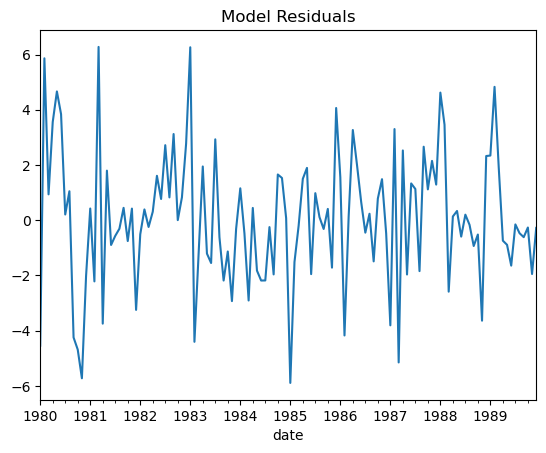

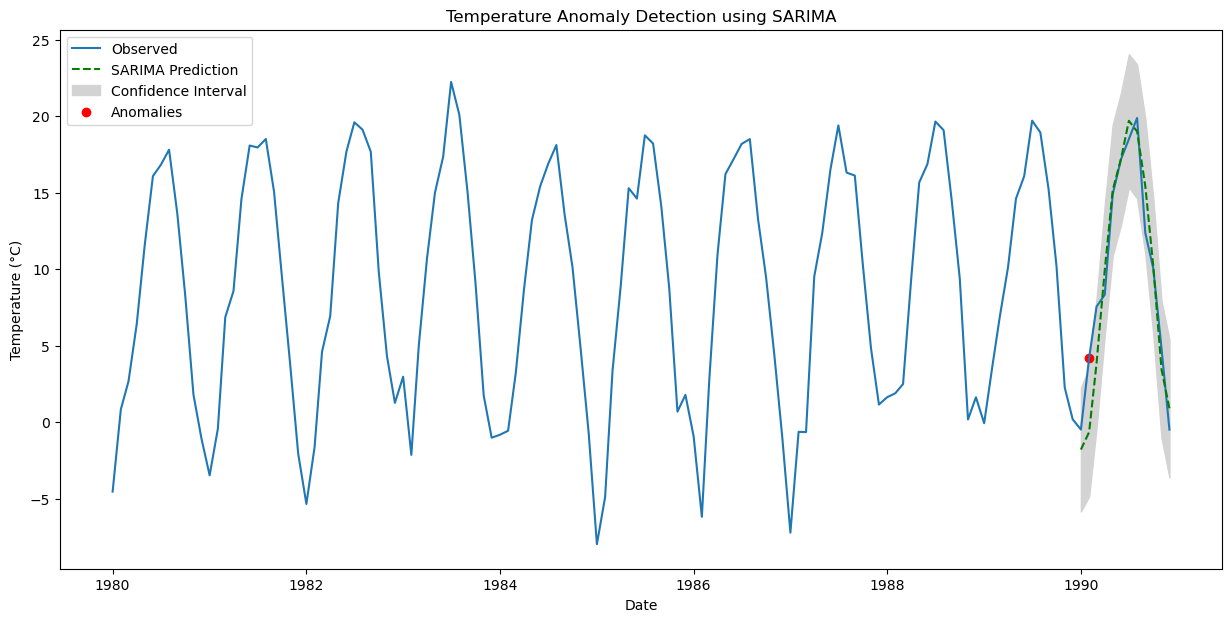

               T_avg  Predicted    Lower     Upper  Anomaly
date                                                       
1990-02-01  4.185714  -0.651061 -4.86734  3.565219     True


In [213]:
model = SARIMAX(train['T_avg'],
                order=(2,1,2),          # (p,d,q)
                seasonal_order=(1,1,1,12), # (P,D,Q,s)
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit(disp=False)
print(f"AIC: {results.aic}")
residuals = results.resid
print(f"Mean of residuals: {residuals.mean()}")
residuals.plot(title='Model Residuals')
plt.show()

# Forecast the 11th year with confidence intervals
forecast = results.get_forecast(steps=len(test))
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Detect anomalies
test = test.copy()
test['Predicted'] = predicted_mean.values
test['Lower'] = conf_int.iloc[:, 0].values
test['Upper'] = conf_int.iloc[:, 1].values
test['Anomaly'] = (test['T_avg'] < test['Lower']) | (test['T_avg'] > test['Upper'])

# Plot
plt.figure(figsize=(15,7))
plt.plot(df_anomalies.index, df_anomalies['T_avg'], label='Observed')
plt.plot(test.index, test['Predicted'], color='green', linestyle='--', label='SARIMA Prediction')
plt.fill_between(test.index, test['Lower'], test['Upper'], color='lightgrey', label='Confidence Interval')
plt.scatter(test[test['Anomaly']].index, test[test['Anomaly']]['T_avg'], color='red', label='Anomalies')
plt.title('Temperature Anomaly Detection using SARIMA')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

# Show detected anomalies
print(test[test['Anomaly']])

## Shrnutí

Úspěšností mého modelu si nejsem příliš jistý, ačkoliv se našla pouze jedna anomálie, model má tak široké hranice pro predikovanou teplotu, že by se tam vlezla pomalu i nukleární zima. Model se tváří úspěšně, ale já si tím teda nejsem jistý.

# (Část 5: Zpětná vazba)
Můj feedback:
Co se týče projektů jsem velice spokojen, projekty, narozdíl od například FLP, byly zábava a něco jsem se reálně naučil.

První projekt bych se nebál udělat větší, ideálně co se týče hardwaru, tedy zapojit více senzorů atd. Zadal bych jej dříve a nechal nás udělat více srandy, myslím si, že by to většina lidí ocenila. Každopádně určitě nechat část s webserverem, byla zajímavá.

Druhý projekt se mi líbil, ale - podobné projekty jsme již realizovali v UPA a MSP, tedy nestěžuju si, jelikož jsem věděl co v projektu dělám, o co jde a projekt se mi celkově líbil a naprosto chápu jeho zasazení do tohoto předmětu. Tím, že tento projekt sedí do tohoto předmětu tak bych jej zde nechal, pomohlo mi to ucelit si na co jsme vlastně dělali ty věci v MSP a UPA, data analysis je dneska důležitá. Takže vlastně nevím, jestli je projekt správně nebo špatně, tedy sedí do předmětu velice dobrým způsobem, je jemně repetetivní, ALE zároveň vidím to, že šablona a zadání je super a pomohla mi ucelit si vědomosti z jiných předmětů, projekt bych teda neměnil a nechal jej být. 